# Continuous Time Finance Midterm Coding part
### Student Name: Yunxiao Xiang 
### Student ID: N12351630

## Problem (b) Monte Carlo Simulation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.random      as ran   
from scipy.stats import norm

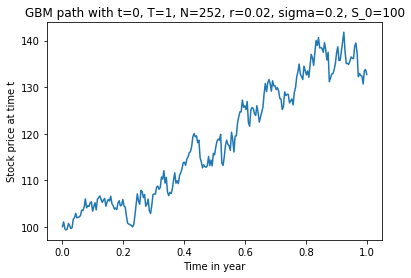

In [2]:
# function that takes as input 
# r: risk free rate,
# sigma: volatitily,
# t: initial time
# T: final time
# n: number of periods in [0,T] 
# s_0: initial stock price
# and output a list storing a GBM path prices
def GeometricBM(r, sigma, t, T, n, s_0):
    # compute dt = T/N
    dt = (T-t)/n
    # initialzie lists to store S_t: S_0 ... S_T have in total N+1 prices
    prices = [0.0]*(n+1)
    prices[0] = s_0
    #  create a list of random generated sample from standard normal
    Z = np.random.normal(loc=0.0, scale=1.0, size=n)
    #  iterate from 1 to N-1, filling prices at time t_i = i*dt
    for i in range(1,n+1):
        prices[i] = prices[i-1] + r*prices[i-1]*dt + sigma*prices[i-1]*(dt**(1/2))*Z[i-1]
        
    return prices


# Test by drawing the path
r = 0.02
sigma =  0.2
t = 0
T = 1
N = 252
S_0 = 100
dt = T/N

x = GeometricBM(r, sigma,t, T, N, S_0)
time = [dt*i for i in range(0,N+1)]

plt.plot(time,x)
plt.title("GBM path with t="+str(t)+", T="+str(T)+", N="+str(N)+", r="+str(r)+", sigma="+ str(sigma)+", S_0="+str(S_0))
plt.xlabel('Time in year')
plt.ylabel("Stock price at time t")
plt.show()

## Problem (c)

In [3]:
# function that takes as input 
# prices: a list of price
# B: a barieer than which options will pay 0 if the price is lower  
# K: the strike price ofthe option
# and outputs a payoff of the down-and-out call
def computePayoff(prices, B, K):
    payoff = 0
    # if all prices are >= barrier
    if( all(S_t >= B for S_t in prices) ):
        payoff = max(0, prices[-1] - K)
    return payoff

# Test against path from (b)
B = 80
K = 110
payoff = computePayoff(x, B, K)
print('The option payoff of test path is: ',payoff)

The option payoff of test path is:  22.7302120213742


## Problem (d)

In [4]:
# function that takes as input 
# r: risk free rate,
# sigma: volatitily,
# T: final time
# n: number of periods in [0,T] 
# s_0: initial stock price
# B: a barieer than which options will pay 0 if the price is lower  
# K: the strike price ofthe option
# N_p: number of simulations
# and output an average of payoff from simulating N paths
def simulation(r, sigma, t, T, n, s_0, B, K, N_p):
    payoffs = [0.0]*N_p
    for i in range(N_p):
        prices = GeometricBM(r, sigma, t, T, n, s_0)
        payoffs[i] = computePayoff(prices, B, K)
    return np.mean(payoffs)*np.exp(-r*(T-t))

# Doing 10^5 simulations
r = 0.02
sigma =  0.2
t = 0
T = 1
N = 252
S_0 = 100
dt = T/N
B = 80
K = 110
N_p = 10**5
monteCarloPrice = simulation(r, sigma, t, T, N, S_0, B, K, N_p)
print("According to Monte Carlo of "+str(N_p)+" simulations, the price of the option is: \n ", monteCarloPrice)

According to Monte Carlo of 100000 simulations, the price of the option is: 
  4.942591428614586


## Problem (m) Numerical PDE Solution

In [5]:
# function that takes as input 
# r: risk free rate,
# sigma: volatitily,
# T: final time
# n: number of periods in [0,T] 
# s_0: initial stock price
# B: a barieer than which options will pay 0 if the price is lower  
# K: the strike price ofthe option
# N_t: number of points of t in grid
# N_x: number of points of x in grid
# R: the upper bound of the system
# and output an average of payoff from simulating N paths
def numericalSol(r, sigma, t, T, s_0, B, K, N_t, N_x, R):
    # Define x grid points
    dx = (R - B)/N_x
    x = [B + dx*k for k in range(N_x+1)]
    # Define M
    M = np.identity(N_x+1)
    for i in range(1,N_x):
        # a_k
        M[i][i-1] = -dt*(-r*x[i]/(2*dx) + sigma**2*(x[i]**2)/(2*(dx**2)))
        # b_k
        M[i][i] = 1 + r*dt + sigma**2*(x[i]**2)*dt/(dx**2)
        # c_k
        M[i][i+1] = -dt*(r*x[i]/(2*dx) + sigma**2*(x[i]**2)/(2*(dx**2)))

    M_inv = np.linalg.inv(M)
    # Set V_Nt =(g(x_0),...,g(x_Nx))
    V_Nt = payoff(x,K)
    # create a matrix to store grid points
    grid_points = np.array([V_Nt]*(1+N_t)).T
    # iterate backward n = Nt,Nt−1,...,1
    for n in range(N_t,0,-1):
        # Compute C_(n-1)
        C = np.concatenate(([0]*N_x,[K*(np.exp(-r*T+r*(t+dt*n))-np.exp(-r*T+r*(t+dt*(n-1))))]))
        # Compute V_(n-1) from V_n
        grid_points[:,n-1] = M_inv@grid_points[:,n] + C

    x_point = int((s_0-B)/dx)
    return grid_points[x_point,0]
    

# function that takes as input
# x: a list of stock prices
# K: strike price (a float)
# and outputs the payoff of the option
def payoff(x, K):
    for i in range(len(x)):
        x[i] = max(x[i] - K,0)
    return x

In [6]:
r = 0.02
sigma =  0.2
t = 0
T = 1
N_t = 252
N_x = 2200
S_0 = 100
R = 300
B = 80
K = 110

numericalPrice = numericalSol(r, sigma, t, T, S_0, B, K, N_t, N_x, R)
print('The price of the option at time t calculated by numerical method of PDE is: \n',numericalPrice)

The price of the option at time t calculated by numerical method of PDE is: 
 4.916733625244862


## Problem (o) Analytical PDE Solution

In [7]:
# function that takes as input 
# r: risk free rate,
# sigma: volatitily,
# T: maturity
# n: number of periods in [0,T] 
# s_0: initial stock price
# B: a barieer than which options will pay 0 if the price is lower  
# K: the strike price ofthe option
# and output the value of option at time t
def analytical(r, sigma, t, T, s_0, B, K):
    return (BSCall(r, sigma, t, T, s_0, B, K) 
            - (s_0/B)**(1 - 2*r/(sigma**2))*BSCall(r, sigma, t, T, B**2/s_0, B, K))

# function that takes as input 
# r: risk free rate,
# sigma: volatitily,
# T: maturity
# n: number of periods in [0,T] 
# s_0: initial stock price 
# K: the strike price ofthe option
# and output the value of a vallina call option at time t
def BSCall(r, sigma, t, T, s_0, B, K):
    d_1 = (np.log(s_0/K) + (r + (sigma**2)/2)*(T - t))/(sigma*np.sqrt(T - t))
    d_2 = d_1 - sigma*np.sqrt(T - t)
    return (s_0*norm.cdf(d_1) - K*np.exp(-r*(T - t))*norm.cdf(d_2))

In [8]:
r = 0.02
sigma =  0.2
t = 0
T = 1
S_0 = 100
B = 80
K = 110
analyticalPrice = analytical(r, sigma, t, T, S_0, B, K)

print('The price of the option at time t calculated by analytical solution of PDE is: \n', analyticalPrice)

The price of the option at time t calculated by analytical solution of PDE is: 
 4.920256808220372


In [9]:
print("According to Monte Carlo of "+str(N_p)+" simulations, the price of the option is: \n",monteCarloPrice)
print('The price of the option at time t calculated by numerical method of PDE is: \n',numericalPrice)
print('The price of the option at time t calculated by analytical solution of PDE is: \n', analyticalPrice)

According to Monte Carlo of 100000 simulations, the price of the option is: 
 4.942591428614586
The price of the option at time t calculated by numerical method of PDE is: 
 4.916733625244862
The price of the option at time t calculated by analytical solution of PDE is: 
 4.920256808220372


Summary: We can see that the price of option at time t computed from above three methods are close, which means our solutions make sense. The real value of option at time t is some number close to 4.92. We can also increase the accuracy of our Monte Carlo and PDE method by doing more simulation and adding more grid points respectively. But that will be a trade off between accuracy and time complexity.